In [1]:
import os
import subprocess
import numpy as np
from scipy.stats import skewnorm
import scipy.io as sio
import matlab.engine

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cmocean

from pycoawst.tools.grid import s2z, cart2polar, rx0, rx1
from pycoawst.utility.general import coriolis

mpl.rcParams['figure.dpi'] = 300

In [915]:
class reef_grid():

    def __init__(self, Lm = 256, Mn = 128, coords = "polar", channels = 1, width_reef = np.pi/6, width_jet = 500, radius_island = 10e3, extent_offshore = 10e3,
                 extent_lagoon = 1e3, extent_reef = 2e3, extent_reefcrest = 100, depth_channel = 20, depth_reef = 2):
        
        self.Lm = Lm
        self.Mn = Mn
        self.coords = coords
        self.nc = channels
        self.Ri = radius_island
        
        self.Ll = extent_lagoon
        self.Lr = extent_reef
        self.Lrc = extent_reefcrest
        
        self.Ro = radius_island + extent_offshore
        self.Rl = radius_island + extent_lagoon
        self.Rr = radius_island + extent_reef
        
        
        self.hj = depth_channel
        self.hr = depth_reef
        
        self.Wj = width_jet
        self.Wr = width_reef
        
        if coords == "polar":
            self.projection = "stereographic"
            self.spherical = "T"
            self.r = np.linspace(self.Ri, self.Ro, Mn)
            self.t = np.linspace(0, self.nc*self.Wr, Lm) - self.nc*self.Wr/2
        elif coords == "xy":
            self.projection = "mercator"
            self.spherical = "F"
            self.x = np.linspace(-self.Wr/2, self.Wr/2, Lm)
            self.y = np.linspace(self.Ri, self.Ro, Mn)
        
    def coord_stretch(self, coord, scale = 3, x0 = 8.5e3):
        """normalized clustering of pts around x0"""
        #https://www3.nd.edu/~gtryggva/CFD-Course2017/Lecture-17-2017.pdf
        
        x = getattr(self, coord)
        Lx = x.max() - x.min()
        xn = (x - x.min())/Lx
        xn0 = (x0 - x.min())/Lx
        xc = xn + scale*(xn0 - xn)*(1 - xn)*xn
        x_stretched = xc*Lx + x.min()
        setattr(self, coord, x_stretched)
        return x_stretched
        
    def set_coords(self):
        if self.coords == "polar":
            self.T, self.R = np.meshgrid(np.flip(self.t), self.r, indexing = "xy")
            self.X, self.Y = self.R*np.cos(self.T), self.R*np.sin(self.T)
        elif self.coords == "xy":
            self.Y, self.X = np.meshgrid(self.y, self.x, indexing = "xy")
    
    def repeat(self, N):
        #self.X = np.tile(self.X, (1,N))
        xadd = self.X[:-1,:]
        yadd = self.Y[:-1,:]
        hadd = self.h[:-1,:]
        for i in range(N-1):
            self.X = np.concatenate((self.X, xadd + self.Wr*(i+1)))
            self.Y = np.concatenate((self.Y, yadd))
            self.h = np.concatenate((self.h, hadd))
        #if self.coords == "polar":
        
    def bathy_tanh(self, x, h0, scale, offset, hmin = 0, sgn = 1):
        return h0*(1 + sgn*np.tanh( (x - offset)/scale)) + hmin
        
    def tanh2(self, x, s = 2.5e-2, w = 0.5):
        """"two sided tanh taper function. smaller s -> steeper roll off"""
        return 0.5*( np.tanh(np.pi*(x + w)/s) - np.tanh(np.pi*(x - w)/s) )

## Analytical Grid: Composite functions

The $\tanh$ and skewnorm distribution functions to be used to create the grid.
$$h(x) = h_0\bigg(1 \pm \tanh{\frac{x - x_0}{s}}\bigg) + h_{min} $$
$$h(x) = A_0\frac{1}{2\sqrt{2\pi}}e^{-\frac{x^2}{2}} \bigg[1 + \textrm{erf}{\bigg(\frac{x}{\sqrt{2}}\bigg)} \bigg] $$

By tapering between various bathymetric subfunctions we can analytically construct the idealized domain. First define the forereef, reef crest, and lagoon bathymetry 
$$ h_f = 200(1 + \tanh{\frac{\pi(y - L_r)}{80}}) $$
$$ h_r = 1105\frac{1}{2\sqrt{2\pi}}e^{-\frac{y^2}{2}} \bigg[1 + \textrm{erf}{\bigg(\frac{y}{\sqrt{2}}\bigg)} \bigg] $$
$$ h_l = 10(1 - \tanh{\frac{\pi y}{50}}) $$
 
By composing these using a taper function of the same form as the $\tanh$ profile as above in the offshore direction, 
and a two-sided tanh taper function in the cross-shore direction (to transition from the reef flat to channel bathymetry smoothly)

$$ t_y = \frac{1}{2}\bigg(1 + \tanh{\frac{\pi(y - L_r)}{100}}\bigg) $$

$$ t_x = \frac{1}{2}\bigg[ \tanh{\frac{\pi(x + W_J)}{1250}} - \tanh{\frac{\pi(x - W_J)}{1250}} \bigg] $$

as follows
$$h_{lr} = h_lt_x + (h_l - h_r)(1 - t_x)$$
$$h(x,y) = h_lr(1 - t_y) + h_ft_y $$

In [917]:
#Cartesian

G = reef_grid(coords = "xy", Lm = 98, Mn = 66, extent_offshore = 6e3, radius_island = 0, width_jet = 100, width_reef = 2e3)
G.coord_stretch("x", x0 = 0, scale = 2)
G.coord_stretch("y", x0 = 1.8e3, scale = 3.3)
G.set_coords()

G.hr = 1.5*8.5e2*skewnorm.pdf(G.Y, a = -2, loc = G.Rr, scale = 80) #crest slope bathymetry
G.hf = G.bathy_tanh(G.Y, h0 = 200, scale = 1e3, offset = G.Rr + 1.75e3, hmin = G.hj, sgn = 1) #forereef bathymetry
G.hl = G.bathy_tanh(G.Y, h0 = G.hj/2, scale = 50, offset = G.Rl, hmin = 2, sgn = -1) #lagoon bathymetry
G.taper_xi = G.tanh2(G.X, s = 1.25e2, w = G.Wj) #azimuthal taper
G.taper_eta = G.bathy_tanh(G.Y, h0 = 0.5, scale = G.Lrc, offset = G.Rr, hmin = 0) #radial taper function

G.hlc = G.hj*G.taper_xi + (G.hl - G.hr)*(1 - G.taper_xi)
G.h = G.hlc*(1 - G.taper_eta) + G.hf*G.taper_eta
G.h[G.h<.5] = .5

#G.repeat(4)

In [916]:
#Polar
G = reef_grid()
G.coord_stretch("r")
G.set_coords()
#G.taper()

G.hr = 11.05e2*skewnorm.pdf(G.R, a = -2, loc = G.Rr, scale = 100) #reef flat bathymetry
G.hf = G.bathy_tanh(G.R, h0 = 500, scale = 1.5e3, offset = G.Rr+1e3, hmin = G.hj*.8, sgn = 1) #forereef bathymetry
G.hl = G.bathy_tanh(G.R, h0 = G.hj/2, scale = 50, offset = G.Rl, hmin = 0, sgn = -1) #lagoon bathymetry
G.taper_eta = G.bathy_tanh(G.R, h0 = 0.5, scale = G.Lrc, offset = G.Rr, hmin = 0) #radial taper function
G.taper_xi = G.tanh2(G.T, w = 0.5*G.Wj/(G.Rr*G.nc*G.Wr))

G.hlc = G.hj*G.taper_xi + (G.hl - G.hr)*(1 - G.taper_xi)
G.h = G.hlc*(1 - G.taper_eta) + G.hf*G.taper_eta
G.h[G.h<.5] = .5

In [918]:
#Compute 3D grid and stiffness metrics

z = s2z(G.h, ns = 10, thetaS = 3.0, thetaB = 2.0, hc  = G.hj) #thermocline deep as channel
stiffness = rx1(z)
beckhaid = rx0(G.h)
display(f"min depth = {G.h.min()}")
display(f"max depth = {G.h.max()}")

Maximum rx1-value = 10.474364278856525
Maximum rx0-value = 0.6299838259628456


'min depth = 0.5'

'max depth = 415.60522294776274'

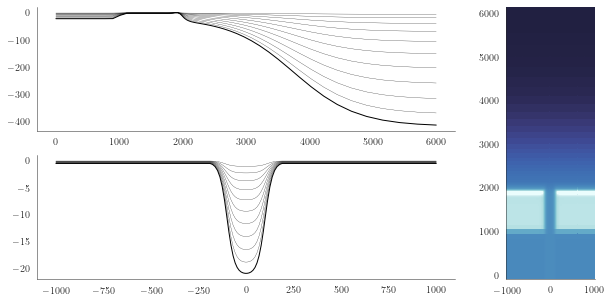

In [1047]:
import matplotlib.gridspec 

i = 25
j = 10
sns.set_style("white")

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios = [2,.425])

fig.add_subplot(gs[0,0])
plt.plot(G.Y[j,:], z[j,:], color = "k", linewidth = 0.25)
plt.plot(G.Y[j,:], -G.h[j,:], color = "k", linewidth = 1)

fig.add_subplot(gs[1,0])
plt.plot(G.X[:,i], z[:,i], color = "k", linewidth = 0.25)
plt.plot(G.X[:,i], -G.h[:,i], color = "k", linewidth = 1)

fig.add_subplot(gs[:,1])
plt.pcolormesh(G.X, G.Y, G.h, norm=colors.LogNorm(vmin = 1, vmax= 1e3), cmap = cmocean.cm.ice_r, shading = "auto" )
plt.gca().axis("equal")

sns.despine()

Figure ?: Cross-shore (a) and alongshore (b) cross-sections of the bathymetry. Notice the irregular spacing functions employed to better resolve reef crest and jet processes. The stretching function used is 

$$ x = L\zeta + a(x_0 - L\zeta)(1 - \zeta)\zeta $$

where $\zeta$ is the normalized coordinate (0-1), $L$ is the length of the domain the given direction, and $a$ is a tuning parameter determining the intensity of grid stretching/expansion about $x_0$.

In [920]:
#Generate .mat file for COAWST mfiles to convert to .nc
grdname = "analytic"

# lon, lat = cart2polar(X,Y)
# rho = {"lon": lon, "lat": lat, "depth": h, "mask": h*0+1}

mask =  G.h*0+1
rho = {"x": G.X, "y": G.Y, "depth": G.h, "mask": mask} 
sio.savemat(f"{grdname}.mat", {"rho": rho, "spherical": G.spherical, "projection": G.projection})

In [907]:
eng = matlab.engine.start_matlab()
eng.cd(os.getcwd(),nargout=0)
eng.mat2roms_mw(f"{grdname}.mat", f"roms_grid.nc", nargout=0)
# eng.roms2swan( f"roms_grid.nc", nargout=0 )
eng.roms2swan( matlab.double(G.X.tolist()), 
               matlab.double(G.Y.tolist()), 
               matlab.double(G.h.tolist()), 
               matlab.double(mask.tolist()),nargout =0 )
eng.quit()

In [1048]:
#impose -fplane if necessary...
string = fr'''ncap2 -s "f=f*0+{coriolis(-30)};" -O {grdname}_grid.nc {grdname}_grid.nc'''
sp = subprocess.run(string, shell = True, check = True)